# Clustering

<img src="images/clusters.png" width="700">

This lecture will cover basic considerations and concepts in clustering data, and introduce a few basic classes of algorithms along with examples.

* Clustering basics
    - Problem statement for clustering
    - Types of clustering problems/algorithms
    - Accuracy and distance metrics
* Expectation-Maximization models
    - k-means and vector quantization
    - Gaussian mixture models
* Density-based models
    - Mean shift
    - DBSCAN
* Hierarchical clustering
    - Dendrograms
    - Agglomerative clustering
* Conclusions

## Clustering basics

### Problem statement

Clustering algorithms seek to identify data points that are similar to each other based on a set of descriptive features.

Clustering algorithms are **unsupervised** since they do not include output labels. This is an example of **exploratory data analysis** in which the goal is to extract insight about the dataset based on its inherent structure, rather than to build a model that predicts an output. These algorithms can be used for data compression, group assignment, searching, and/or model evaluation or feature extraction for supervised models.

### Types of problems/algorithms

There are a few key types of clustering algorithms:

**Expectation-maximization** algorthims iteratively compute "expected" clusters and then "maximize" the parameters of the cluster to optimize the expectations. This is somewhat similar to an iterative version of a generalized linear classification algorithm: "classes" are assigned, then boundaries are found to optimize a cost function based on these classes. After this optimization the new class boundaries are used to assign classes again, and the optimization is repeated with new "class" labels.

**Density-based** algorithms utilize local information about data points to identify regions where the data has similar density. Regions where there is substantially lower density of data form boundaries between these clusters. This is somewhat similar to k-nearest neighbors where classes are defined by local environments.

**Hierarchical** algorithms map out the full network of connectivity within a dataset, then use a variable distance cutoff to assign clusters. These algorithms can be understood visually through a dendrogram, and have relatively few hyperparameters but they are more computationally demanding.

A few considerations when selecting a clustering algorithm:

* Some algorithms requre defining the number of clusters explicitly (e.g. most expectation-maximization algorithms) while others find this implicitly based on choice of hyperparameters (e.g. density-based or hierarchical)

* Some algorithms allow **mixed membership** where points can belong to multiple clusters based on probabilities.

* Some algorithms can identify/ignore outliers/noise (e.g. density-based), while others attempt to assign clusters to all points (e.g. expectation-maximization and hierarchical).

### Accuracy and distance metrics

Computing the accuracy of unsupervised models is difficult because there is no "right answer". However, it is possible to compute some quantitative metrics based on the concept of a cluster.

* **Silhouette score** is defined for *each point* and is related to two distances:
    - $a$ is the average distance between a point and all other points in its cluster
    - $b$ is the average distance between a point and the points in the next nearest cluster
    - $S = \frac{b-a}{max(a,b)}$ is the silhoutte score
    - $S = -1$ implies totally incorrect, $S=1$ implies totally correct
    - Works best for dense, well-separated clusters
    - Does not work well for density-based clusters (e.g. DBSCAN)
    
The silhouette score can help identify individual points that are not well-clustered, or an average/max silhouette score can be used to evaluate the quality of the entire clustering model. Other metrics can be used to evaluate the overall model:

* **Variance ratio criterion** or "Calinski-Harabaz score" is related to the "within class" variance (similar to intra-class variance for classificaiton) and the "between class" variance (similar to the interclass variance for classification). The mathematical definition is available [here](https://www.tandfonline.com/doi/abs/10.1080/03610927408827101) but is beyond the scope of this course.
    - Variance ratio will be higher for dense and well-separated clusters
    - Not bounded so it can be difficult to know what is "good" and what is "bad"
    - Does not work well for density-based clusters (e.g. DBSCAN)
    
These approaches can be utilized to identify hyperparameters such as the number of clusters in the case where there is no *a priori* expectation about the number of clusters.

Another common technique is to use clustering for classification problems. In this case the error metrics from classification can be applied (e.g. confusion matrices, precision, recall, etc.). The comparison of clustering and classification can provide insight into how well the classes are captured by proximity in the feature space.

Finally, it is worth noting that essentially all clustering algorithms rely on some form of **distance metric**. The way that distance is defined can have substantial impact on how clustering analyses perform. Some common choices to compute the distance between two points $i$ and $j$:

* Euclidean distance ($L_2$ norm): $D_{ij} = \sqrt{sum((\vec{x}_i - \vec{x}_j)^2)}$
* Manhattan distance ($L_1$ norm): $D_{ij} = sum(abs(\vec{x}_i - \vec{x}_j))$
* Chebyshev distance ($L_\infty$ norm): $D_{ij} = max(abs(\vec{x}_i - \vec{x}_j))$
* Minkowsky distance ($L_P$ norm): $D_{ij} = (sum((\vec{x}_i - \vec{x}_j)^P)^{1/P}$

It is also possible to define a weighted distance metric that can implicitly standardize the data, or weight nearby points much higher than far away points. An example is the Mahalanobis distance:

* Mahalanobis distance: $D_{ij} = (\vec{x}_i - \vec{\mu})^T \underline{\underline{C}}^{-1} (\vec{x}_j - \vec{\mu})$
    - $\mu$ is the mean vector
    - $\underline{\underline{C}}$ is the covariance matrix
    
For simplicity we will typically default to Euclidean distance in most examples; however, changing distance metrics can substantially improve performance in real problems so it is worthwhile to experiment. This is usually as simple as changing a keyword for `scikit-learn` models, or writing a short function to compute the necessary distance.

## Expectation-maximization models

### k-means

The k-means algorithm is the simplest and most intuitive clustering algorithm. It performs remarkably well under a number of assumptions:

* Number of clusters are known
* Clusters are roughly spherical
* Clusters are separated by linear boundaries

Even if these assumptions are violated, it often works anyway, especially in high dimensions (the "blessing" of dimensionality).

The k-means algorithm works using the principal of **expectation-maximization**. This is an iterative type of algorithm that contains two basic steps:

* Expectation: Assign points based on some "expectation" metric.
* Maximization: Revise expectations based on maximizing a fitness metric.

In the case of k-means we:

* Expect that points close to the center of a cluster belong to that cluster
* Maximize the proximity of points to the center of a cluster by moving the center

This process is interated until convergence.

Let's look at a few toy data sets and a toy implementation of k-means:

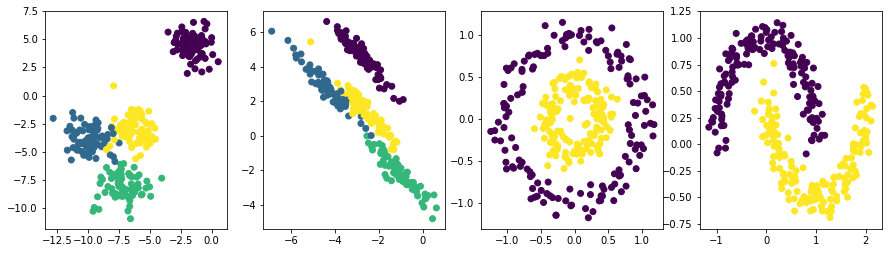

In [77]:
import pylab as plt
import numpy as np
from sklearn.datasets import make_blobs, make_moons, make_biclusters, make_circles
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabaz_score

random_state = 1
k = 4
N = 300

X_blobs, y_blobs = make_blobs(N,centers=k,random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X_blobs, transformation)

X_circles, y_circles = make_circles(N,noise=0.1, factor=0.4, random_state=random_state)

X_moons, y_moons = make_moons(N, noise=0.1, random_state=random_state)

fig, axes = plt.subplots(1,4, figsize=(15,4))

axes[0].scatter(X_blobs[:,0], X_blobs[:,1], c=y_blobs)
axes[1].scatter(X_aniso[:,0], X_aniso[:,1], c=y_blobs)
axes[2].scatter(X_circles[:,0], X_circles[:,1], c=y_circles)
axes[3].scatter(X_moons[:,0], X_moons[:,1], c=y_moons)

In [78]:
def dist(pt1, pt2):
    "Euclidean distance between two points"
    #note that this can also be performed with np.linalg.norm(pt1-pt2)
    return np.sqrt(sum([(xi-yi)**2 for xi, yi in zip(pt1, pt2)]))

def expected_assignment(pt, cluster_centers):
    dists = [dist(pt,ci) for ci in cluster_centers] #<- find distance to each center
    min_index = dists.index(min(dists)) #<- find the index (cluster) with the minimum dist
    return min_index

def new_centers(cluster_points, centers):
    centers = list(centers)
    for i,ci in enumerate(cluster_points):
        if ci != []:
            centers[i] = np.mean(ci, axis=0)
    return centers

Now we need an "initial guess" of cluster centers and we can apply the algorithm to a toy dataset:

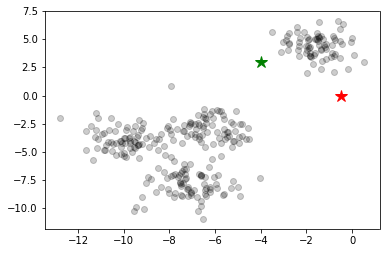

In [79]:
X = X_blobs
y = y_blobs

#cluster_centers = ([-0.5,0], [0.5,0])
cluster_centers = ([-0.5,0], [-4,3])
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], color='k', alpha=0.2)
colors = {0:'r', 1:'g', 2:'b',3:'m'}
for i,ci in enumerate(cluster_centers):
    ax.plot(ci[0], ci[1], marker='*', markersize='12', color=colors[i])

#### How many clusters will the algorithm find? Approximately where do you expect the centers to be?

Run the cell below repeatedly to see how the algorithm converges. Re-run the cell above to re-start the algorithm.

[-6.33399468 -6.24628882]
[-6.12498003 -0.42339798]


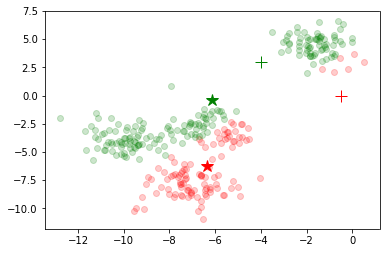

In [80]:
fig, ax = plt.subplots()
# Plot old centers
for i,ci in enumerate(cluster_centers):
    ax.plot(ci[0], ci[1], marker='+', markersize='12', color=colors[i])
    
# Which cluster do we "expect" each point to belong to?
clusters = [[],[],[],[]]
for pt in X:
    cluster_idx = expected_assignment(pt, cluster_centers)
    clusters[cluster_idx].append(pt)
    
# What centers best represent these new assignments?
cluster_centers = new_centers(clusters, cluster_centers)

# Plot new assignments
for i, ci in enumerate(clusters):
    for pt in ci:
        ax.plot(pt[0], pt[1], marker='o', color=colors[i], alpha=0.2)
        
# Plot new centers
for i,ci in enumerate(cluster_centers):
    print(ci)
    ax.plot(ci[0], ci[1], marker='*', markersize='12', color=colors[i])
    

#### What will happen if this is applied to other datasets? How sensitive are answers to the initial guesses?

In practice it is more efficient to utilize the `scikit-learn` implementation of `KMeans`:

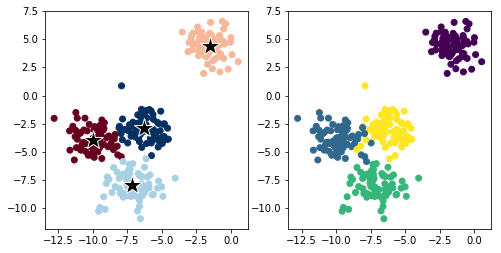

In [84]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=4, random_state=random_state)
model.fit(X)
y_predict = model.predict(X)
centers = model.cluster_centers_

fig, axes = plt.subplots(1,2,figsize=(8,4))
axes[0].scatter(X[:,0], X[:,1], c=y_predict, cmap='RdBu')
axes[1].scatter(X[:,0], X[:,1], c=y)
for center in centers:
    x_i = center[0]
    y_i = center[1]
    axes[0].plot(x_i, y_i, marker='*', color='k', mec='w', markersize=20)

### Vector quantization

"Vector quantization" is a common application of clustering algorithms. The k-means algorithms is utilized to identify clusters of similar vectors, then each vector is replaced with the centroid of its cluster. This is often used for data compression. First let's start with a 1D example:

(array([ 3., 25., 44., 38., 71., 40.,  5., 15., 44., 15.]),
 array([-12.7907975, -11.4591162, -10.1274349,  -8.7957536,  -7.4640723,
         -6.132391 ,  -4.8007097,  -3.4690284,  -2.1373471,  -0.8056658,
          0.5260155]),
 <a list of 10 Patch objects>)

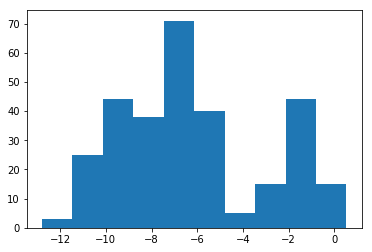

In [141]:
X_1d = X[:,0]

fig, ax = plt.subplots()
ax.hist(X_1d, bins=10)

This histogram is a "quantized" version of the original data. Instead of all 300 (or $N$) x, y values the data can now be represented with 10 (or $bins$) bin locations and 10 counts. This approximates the entire dataset with substantially less information!

Of course we can do better than this, since we know that some bins will be empty (or approximately empty). 

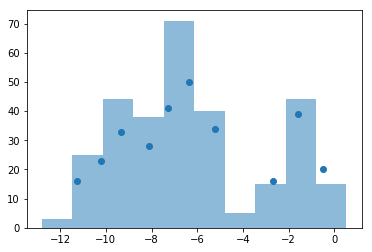

In [142]:
k = 10
model = KMeans(n_clusters=k, random_state=random_state)
X_1d_skl = X_1d.reshape(-1,1)
model.fit(X_1d_skl)
y_predict = model.predict(X_1d_skl)
centers = model.cluster_centers_
unique, counts = np.unique(y_predict, return_counts=True) #<- useful way to count occurences!

fig, ax = plt.subplots()
ax.hist(X_1d, bins=k, alpha=0.5)
ax.scatter(centers,counts)

We can see that k-means performs similarly to the histogram binning, though there are some differences based on initial guesses and the alignment of the bins\clusters with the data. This is a well-known issue with histograms an can be overcome with "kernel density estimation". This is beyond the scope of the lecture, but we will show it here for comparison:

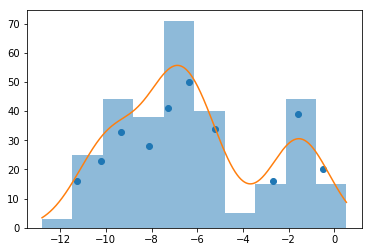

In [143]:
from scipy.stats import gaussian_kde

kde = gaussian_kde(X_1d)
scale_factor = ((max(X_1d) - min(X_1d))/k)*len(X_1d)
xx = np.linspace(min(X_1d), max(X_1d), 1000)
ax.plot(xx, kde(xx)*scale_factor)
fig

Generally k-means tends to give a slightly better, or at least equally good, estimate of the underlying distribution. The issues with histograms only get worse when going to higher dimensions.

#### Consider a 3-dimensional dataset with 255 bins in each dimension. How many bins are needed to represent this space?

This example corresponds exactly to the RGB color pallette used by computers. We can use this test space to illustrate vector quantization in action. We will work with a sample image of the Atlanta skyline.

In [150]:
! pip install imageio

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Shape: (1703, 3397, 3)
Max value: 255
Min value: 0


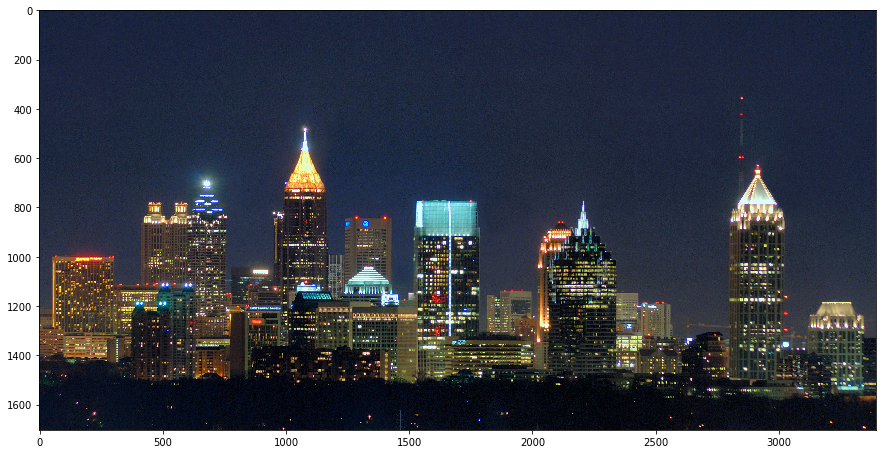

In [159]:
from imageio import imread

atl = imread("images/atlanta.jpg") #<-load the image
print('Shape:', atl.shape)
print('Max value:',atl.max())
print('Min value:', atl.min())
atl = np.array(atl, dtype=np.float64) / 255

fig, ax = plt.subplots(figsize=(15,8))
ax.imshow(atl)

We need to recognize that this image is simply a list of 1703 $\times$ 3397 = 5785091 data points in the 3-dimensional RGB color space. We can re-shape the image into a list of 3D points:

(5785091, 3)
[0.08627451 0.12941176 0.2       ]


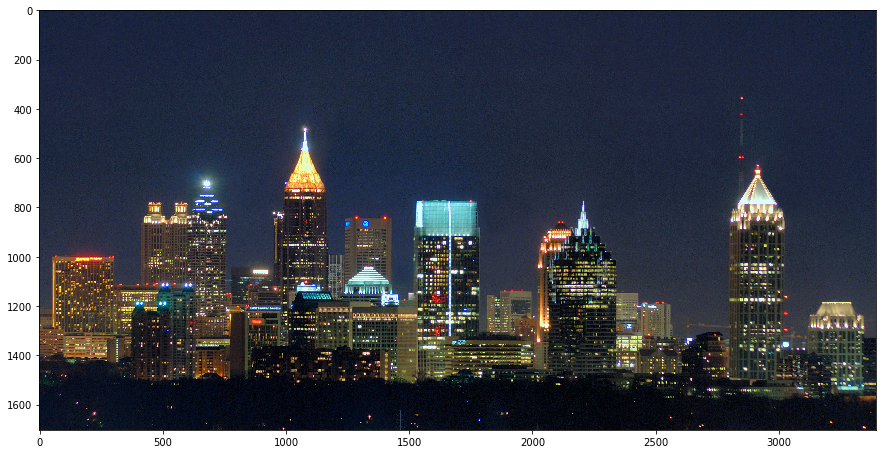

In [164]:
def deconstruct_image(img):
    n_x, n_y, rgb = img.shape
    N = n_x*n_y
    return img.reshape(N,rgb)

def reconstruct_image(points, n_x,n_y):
    N, rgb = points.shape
    return points.reshape(n_x,n_y,rgb)

n_x,n_y,rgb = atl.shape
img_X = deconstruct_image(atl)
print(img_X.shape)
print(img_X[0])

img = reconstruct_image(img_X, n_x,n_y)
fig, ax = plt.subplots(figsize=(15,8))
ax.imshow(img)

Lets see how many colors are in this image:

In [175]:
# This code block takes too long to run due to the image size! The answer is
"""
uniques = []
for pt in img_X:
    unique = True
    for pt_j in uniques:
        if (pt_j == pt).all():
            unique = False
    if unique == True:
        uniques.append(pt)
        print(len(uniques))
print(len(uniques))
"""

'\nuniques = []\nfor pt in img_X:\n    unique = True\n    for pt_j in uniques:\n        if (pt_j == pt).all():\n            unique = False\n    if unique == True:\n        uniques.append(pt)\n        print(len(uniques))\nprint(len(uniques))\n'

Now the goal is to compress the image by identifying the characteristic colors, and approximating each pixel with on of the $N$ characteristic colors instead of one of the 16 million possible colors. Let's consider the case where $N=64$. We don't want to train the k-means model on all 500k data points, so we will take a sub-sample of 1000 to start with.

In [183]:
from sklearn.utils import shuffle

k = 16
N = 1000
model = KMeans(n_clusters=k, random_state=random_state)
X_train = shuffle(img_X, random_state=random_state)[:1000] #<- shuffle the points and take the first 1000 samples
model.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=16, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

#### How can we find the approximated colors for all the data points in the image?

In [184]:
labels = model.predict(img_X)
codebook = model.cluster_centers_

print(labels.shape)
print(codebook.shape)

(5785091,)
(16, 3)


Now we need to reconstruct the image, but this time we need to reconstruct the colors as well as the shape.

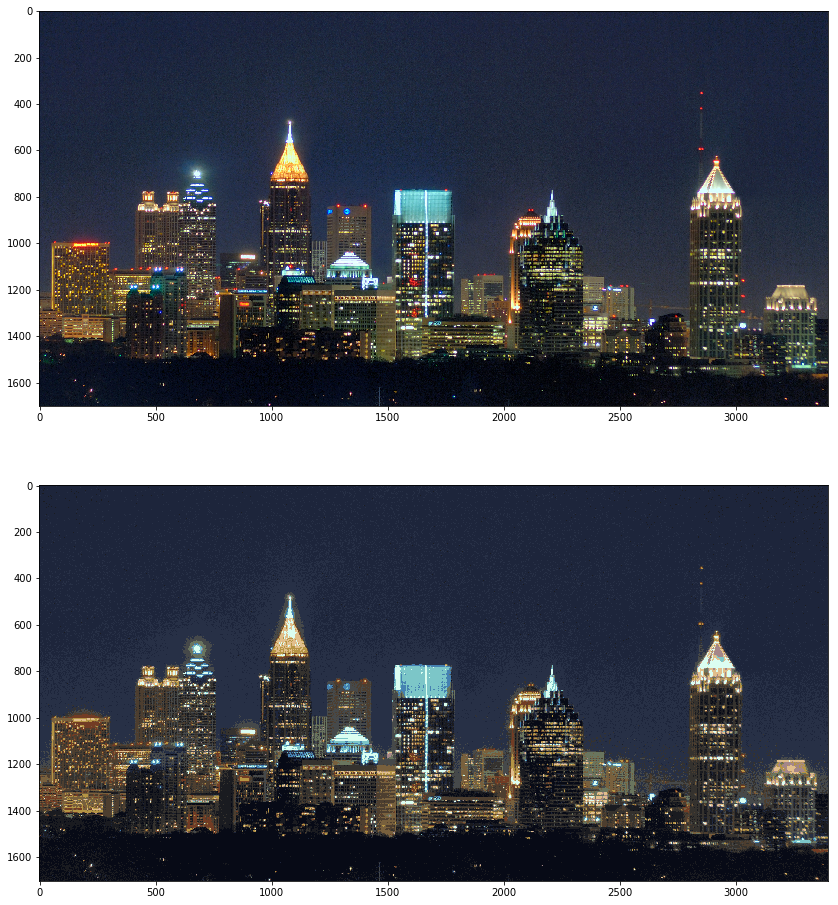

In [185]:
def reconstruct_quantized_image(labels, codebook, n_x,n_y):
    img = np.zeros((n_x,n_y,codebook.shape[1]))
    idx = 0
    for i in range(n_x):
        for j in range(n_y):
            img[i][j] = codebook[labels[idx]]
            idx += 1
    return img

compressed_img = reconstruct_quantized_image(labels, codebook, n_x, n_y)
fig, axes = plt.subplots(2,1,figsize=(15,16))
axes[0].imshow(atl)
axes[1].imshow(compressed_img)

#### How many total numbers are needed to represent the original image? How many for the compressed image?

### Gaussian mixture models

## Density-based models

### Mean shift algorithm

### DBSCAN

## Hierarchical models

### Dendrograms

### Agglomerative hierarchical clustering

## Conclusions

## Further reading

* [Evaluation of clustering algorithms](http://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)
* [Overview of 5 key clustering algorithms](https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68)
* [Python Data Science Handbook: k-Means](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html)
* [Python Data Science Handbook: GMM](https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html)
* [Color quantization example](http://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html)
* Hastie Ch. 13 (pg. 459)